In [ ]:
# import relevant packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.standard import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap

# Load in the datasets 
sst = xr.open_dataset('sst_monthly.nc')['sst']
msl = xr.open_dataset('msl_monthly.nc')['msl']
v10 = xr.open_dataset('v10_monthly.nc')['v10']
u10 = xr.open_dataset('u10_monthly.nc')['u10']

In [ ]:
# slice data for the specified region: 30S–30N, 100E–70W
region = dict(latitude=slice(30, -30), longitude=slice(100, 290)) # 70W == 360-70=290 degrees

# reduce datasets to information for the specified region only
sst_red = sst.sel(**region)
msl_red = msl.sel(**region)
v10_red = v10.sel(**region)
u10_red = u10.sel(**region)

In [ ]:
# flatten spatial dimensions for all variables, include rolling bi-monthly condensation
msl_flat = msl_red.stack(space=('latitude', 'longitude'))
v10_flat = v10_red.stack(space=('latitude', 'longitude'))
u10_flat = u10_red.stack(space=('latitude', 'longitude'))
sst_flat = sst_red.stack(space=('latitude', 'longitude'))

# identify sea coordinates (non-NaN points in SST) across all time steps
valid_points = ~sst_flat.isnull().any(dim='time')

# reduce ALL datasets to sea-only points
sst_sea = sst_flat[:, valid_points]
msl_sea = msl_flat[:, valid_points]
v10_sea = v10_flat[:, valid_points]
u10_sea = u10_flat[:, valid_points]

In [39]:
"""relevant global variables"""

# titles for the subplots
names = ["Sea Surface Temperature",
            "Mean Sea Level Pressure",
            "10m Meridional Wind Speeds (v10)",
            "10m Zonal Wind Speeds (u10)"]

# define bi-monthly season labels
bi_monthly_labels = [
    "Dec-Jan", "Jan-Feb", "Feb-Mar", "Mar-Apr", "Apr-May", "May-Jun",
    "Jun-Jul", "Jul-Aug", "Aug-Sep", "Sep-Oct", "Oct-Nov", "Nov-Dec"
]

# store coordinates of the whole region
gridpoints = []
for i in range(len(msl_flat.space.values)):
    coord = msl_flat.space.values[i]
    gridpoints.append(np.array(coord).tolist())

# store coordinates of only the sea data
seapoints = []
for i in range(len(sst_sea.space.values)):
    coord = sst_sea.space.values[i]
    seapoints.append(np.array(coord).tolist())

# find indices of sea points in the whole grid - used for plotting loading patterns 
# NB: not a very efficient way to do this, takes a while to run (~45s)
sea_inds = [ np.where( (np.array(gridpoints) == coord).all(axis=1))[0][0] for coord in seapoints ]
land_inds = np.setdiff1d( np.arange(len(gridpoints)), sea_inds )

# array of grid points in terms of latitude and longitude (for plotting)
lat = msl_red['latitude'].to_numpy()
lon = msl_red['longitude'].to_numpy()

# blank canvas of the region to place results onto
canvas = np.zeros( (len(lat), len(lon)) )

# convert 1D indices into 2D indices - used for placing results onto the canvas 
sea_rows, sea_cols = np.unravel_index(sea_inds, canvas.shape)
land_rows, land_cols = np.unravel_index(land_inds, canvas.shape)

### grouping into bi-monthly seasons

In [ ]:
# FUNCTION: group a dataset into bi-monthly seasons
def groupData(data):

    # take the mean between adjacent months
    ds = data.rolling(time=2, center=True).mean().dropna('time')

    # create a bi-monthly index for each time point
    # input: time = individual month as an xarray coordinate
    def assign_bimonthly_group(time):
        
        # get month as an integer 
        month = time.values

        # return relevant bi-monthly index
        if month == 12:  # December -> "Dec-Jan"
            return "Dec-Jan"
        else:
            return bi_monthly_labels[month]

    # create new coordinate in the dataset: bimonthly_season
    ds = ds.assign_coords( bimonthly_season=("time", [ assign_bimonthly_group(t) for t in ds["time"].dt.month ]) )

    # group the data by the bimonthly season
    grouped = ds.groupby("bimonthly_season")

    return grouped


In [37]:
"""organise the datasets:
1. group datasetse into bi-monthly seasons
2. normalise them (i.e. find anomaly matrices)
3. extract each bi-monthly group of each dataset and store in a list for each month
4. combine each variable's data into a single dataset, for each month, by concatenating along the spatial dimension
"""
def organiseData():

    # *** step 1
    # group each dataset into the bimonthly seasons
    sst_grouped = groupData(sst_sea)
    msl_grouped = groupData(msl_sea)
    v10_grouped = groupData(v10_sea)
    u10_grouped = groupData(u10_sea)

    # *** step 2
    # normalising procedure: subtract the mean and divide by the standard deviation
    def normalise(data):
        mean = data.mean(dim='time', skipna=True)
        std = data.std(dim='time', skipna=True)
        return (data - mean) / std

    sst_normalised = normalise(sst_grouped)
    msl_normalised = normalise(msl_grouped)
    v10_normalised = normalise(v10_grouped)
    u10_normalised = normalise(u10_grouped)
    
    # *** step 3
    # lists to contain data for 4 variables
    DJ = []
    JF = []
    FM = []
    MA = []
    AM = []
    MJ = []
    JJ = []
    JA = []
    AS = []
    SO = []
    ON = []
    ND = []

    # select the particular bi-monthly seasons from each dataset and organising into the lists
    normalised_datasets = [sst_normalised, msl_normalised, v10_normalised, u10_normalised]
    for i in range(4):
        ds = normalised_datasets[i]
        DJ.append(ds.sel(bimonthly_season = 'Dec-Jan'))
        JF.append(ds.sel(bimonthly_season = 'Jan-Feb'))
        FM.append(ds.sel(bimonthly_season = 'Feb-Mar'))
        MA.append(ds.sel(bimonthly_season = 'Mar-Apr'))
        AM.append(ds.sel(bimonthly_season ='Apr-May'))
        MJ.append(ds.sel(bimonthly_season = 'May-Jun'))
        JJ.append(ds.sel(bimonthly_season = 'Jun-Jul'))
        JA.append(ds.sel(bimonthly_season = 'Jul-Aug'))
        AS.append(ds.sel(bimonthly_season = 'Aug-Sep'))
        SO.append(ds.sel(bimonthly_season = 'Sep-Oct'))
        ON.append(ds.sel(bimonthly_season = 'Oct-Nov'))
        ND.append(ds.sel(bimonthly_season = 'Nov-Dec'))

    # *** step 4
    # concatenate along the SPATIAL DIMENSION to use for EOF analysis
    DJ_comb = xr.concat(DJ, dim='space')
    JF_comb = xr.concat(JF, dim='space')
    FM_comb = xr.concat(FM, dim='space')
    MA_comb = xr.concat(MA, dim='space')
    AM_comb = xr.concat(AM, dim='space')
    MJ_comb = xr.concat(MJ, dim='space')
    JJ_comb = xr.concat(JJ, dim='space')
    JA_comb = xr.concat(JA, dim='space')
    AS_comb = xr.concat(AS, dim='space')
    SO_comb = xr.concat(SO, dim='space')
    ON_comb = xr.concat(ON, dim='space')
    ND_comb = xr.concat(ND, dim='space')

    all_data = [DJ_comb, JF_comb, FM_comb, MA_comb, AM_comb, MJ_comb, JJ_comb, JA_comb, AS_comb, SO_comb, ON_comb, ND_comb]
    
    return all_data

all_data = organiseData()

In [32]:
# FUNCTION: uses Eof package to perform analysis on the bi-monthly datasets of 4 variables
# OUTPUT: solver = object returned by Eof package; eofs = spatial patterns, pcs = timeseries data of principal components
# Takes < 1.5min for all the seasons
def getEofs():

    # lists to contain the solved EOF matrices and PC1 timeseries for each bi-monthly season
    eofs = []
    pcs = []
    for i in range(12):
        print(f"Working on the {i}th season...")        # printing a status update at each iteration

        data_matrix = all_data[i].fillna(0).values      # replacing null values with 0s
        solver = Eof(data_matrix)                       # finding and saving results
        eofs.append(solver.eofs(neofs=1))
        pcs.append(solver.pcs(npcs=1))
    return solver, eofs, pcs

# call the function
solver, eofs, pcs = getEofs()

Working on the 0th season...
Working on the 1th season...
Working on the 2th season...
Working on the 3th season...
Working on the 4th season...
Working on the 5th season...
Working on the 6th season...
Working on the 7th season...
Working on the 8th season...
Working on the 9th season...
Working on the 10th season...
Working on the 11th season...


In [ ]:
# ensuring consistent sign convention throughout the 4x12 result sets
def signConvention():
    for i in range(len(eofs)):
        if eofs[i][0, 0] < 0:  
            eofs[i] = -eofs[i]  
            pcs[i] = -pcs[i]    
signConvention()

In [40]:
# finding the variance (eigenvalues) for each variable
def get_Variance():
    explained_variance_all = solver.varianceFraction(neigs=4) * 100
    for i, variance in enumerate(explained_variance_all):
        print(f"{names[i]}: {variance:.2f}%")

get_Variance()

Sea Surface Temperature: 18.54%
Mean Sea Level Pressure: 11.13%
10m Meridional Wind Speeds (v10): 7.18%
10m Zonal Wind Speeds (u10): 4.45%


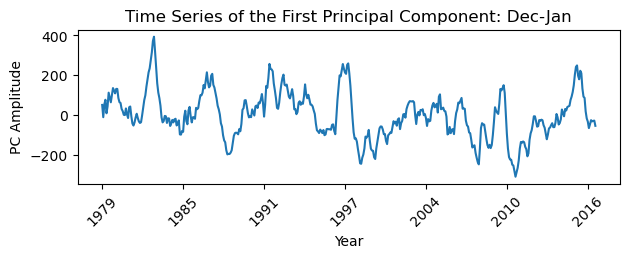

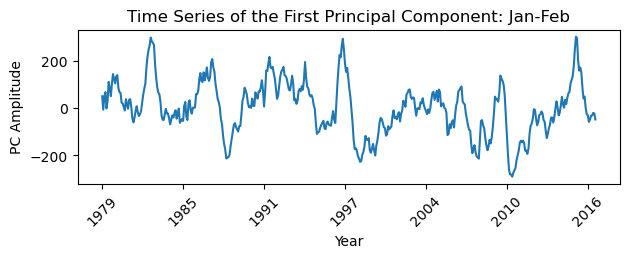

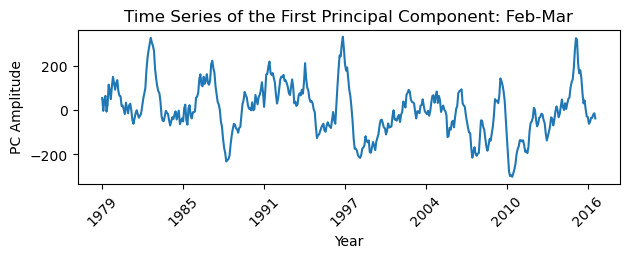

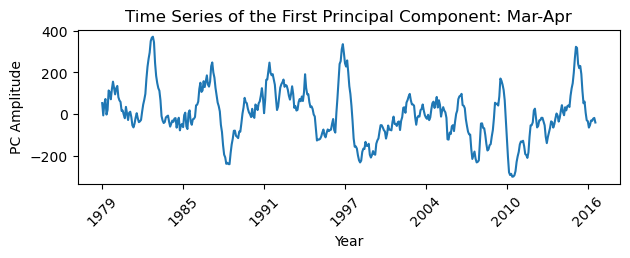

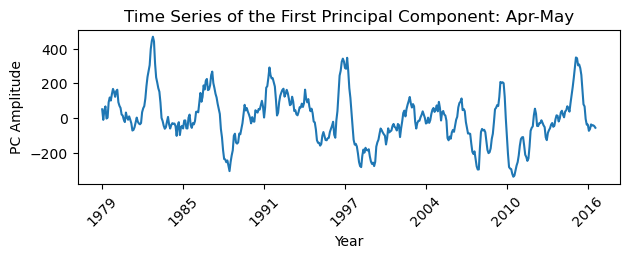

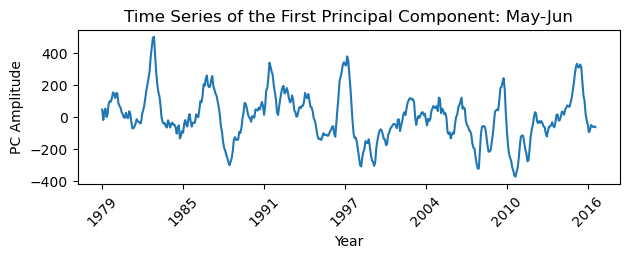

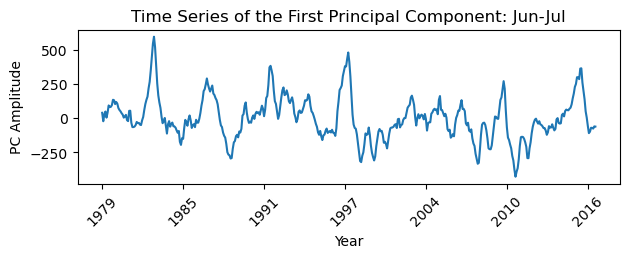

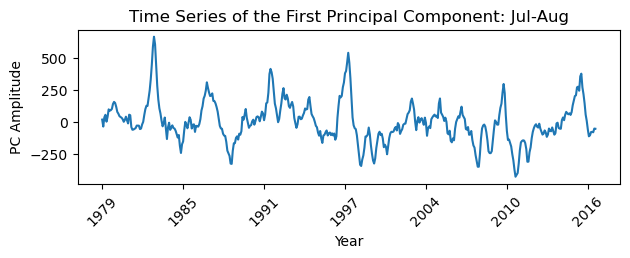

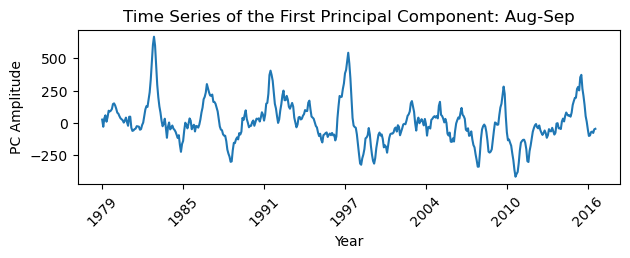

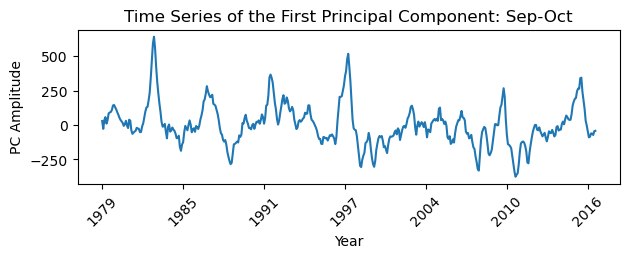

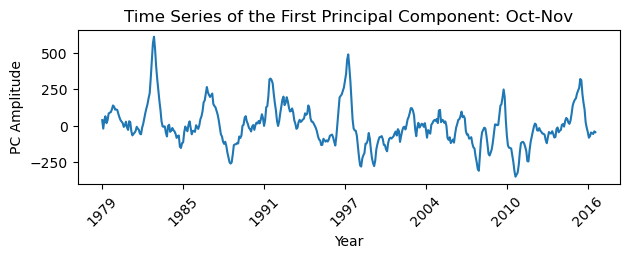

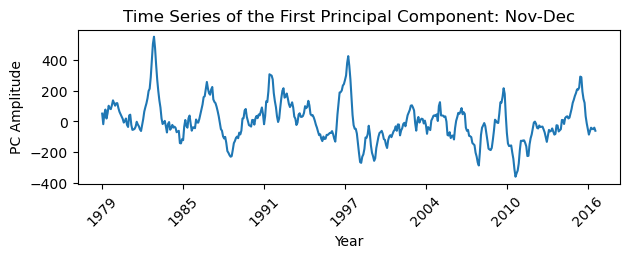

In [ ]:
# pcs = pcs timeseries to plot
def plotTimeSeries():

    # save every 75th year and its index to plot on the x axis
    indices =[]
    years = []
    xvals = sst.time.to_numpy()         # make time coordinates iterable
    for i, year in enumerate(xvals):
        if i%75 == 0:
            indices.append(i)
            years.append(year.astype('datetime64[Y]').astype(int) + 1970)
    
    # plot each bi-monthly season's time series
    for i in range(12):

        plt.figure(figsize = (7,2))
        plt.plot(pcs[i])
        plt.xticks(indices, years, rotation = 45)
        plt.title(f'Time Series of the First Principal Component: {bi_monthly_labels[i]}')
        plt.xlabel('Year')
        plt.ylabel('PC Amplitude')
        plt.show()

plotTimeSeries(pcs)

In [ ]:
# function to plot the loading patterns (contour maps) of the EOF analyses
# INPUT: loadings = eofs[0] output from the solver
def plot_loadingPatterns(loadings, month):

    # prepare figure
    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15,8), )
    ax=ax.ravel()

    # endpoints of the slices for plotting
    slices = [0, len(sst_normalised[1]), 
              len(msl_normalised[1]), 
              len(u10_normalised[1]), 
              len(v10_normalised[1])]
    start = slices[0]       # initialise slice locations
    end = slices[1]

    # plot each of the loading patterns
    for i in range(4):

        # slice the block of (sea) data corresponding to this variable
        block = loadings[start:end]

        # place data onto the canvas
        canvas[sea_rows, sea_cols] = block                  # place sea data at sea coordinates
        canvas[land_rows, land_cols] = 0                    # place 0s at land coords

        # plot the loading pattern
        T = ax[i].contourf(lon, lat, canvas, cmap='coolwarm')
        ax[i].set_title(names[i])
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        
        plt.colorbar(T, ax=ax[i], shrink = 0.6)
    
        # draw black coastlines and colour land white
        m = Basemap(llcrnrlat=lat.min(), urcrnrlat=lat.max(), llcrnrlon=lon.min(), urcrnrlon=lon.max(), ax=ax[i])
        m.drawcoastlines(ax=ax[i], linewidth=0.8)
        m.fillcontinents(color='white')

            
        ax[i].set_xticks(lon[::50])
        ax[i].set_yticks(lat[::20])

        # update the start and end points for the next slice
        start = end
        if i < 3:
            end += slices[i+2] 

    plt.suptitle(f"First EOF Loading Patterns: {month}")
    plt.tight_layout()
    plt.show()

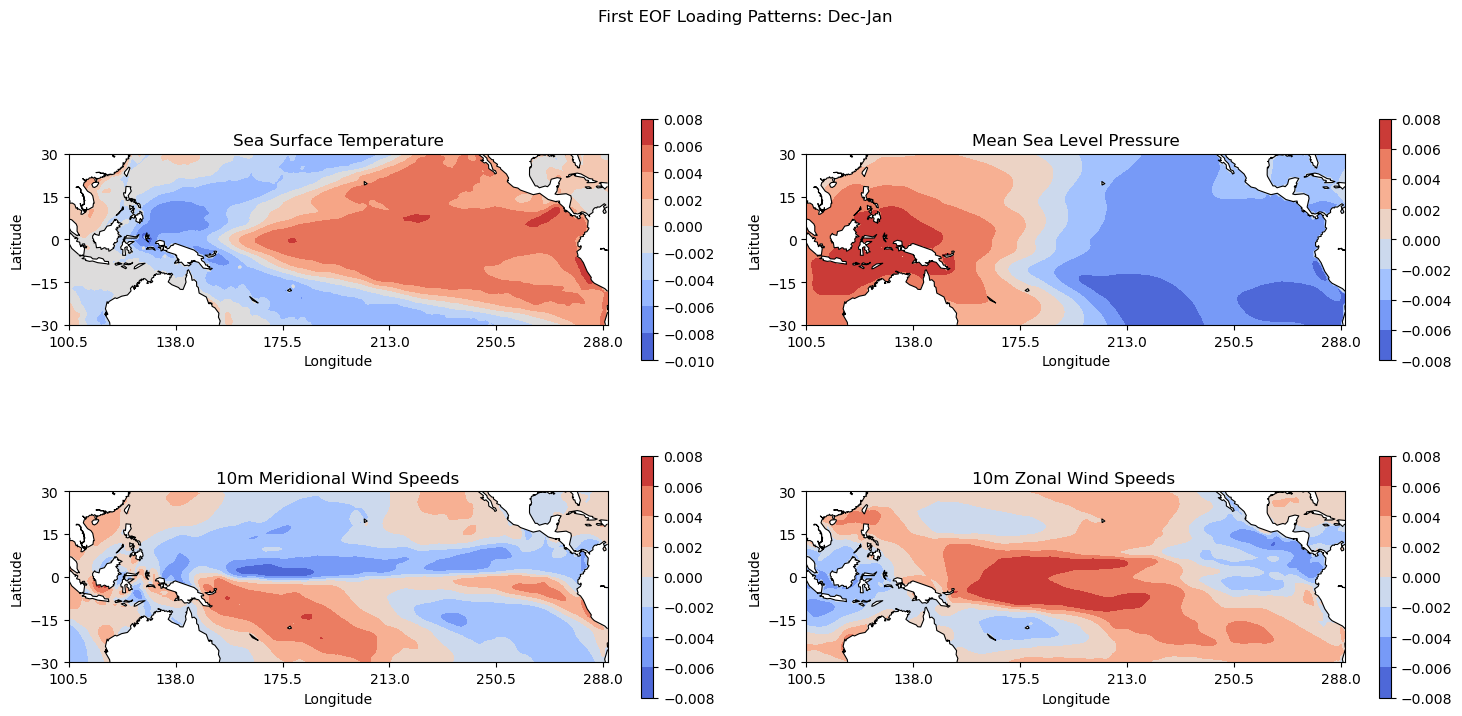

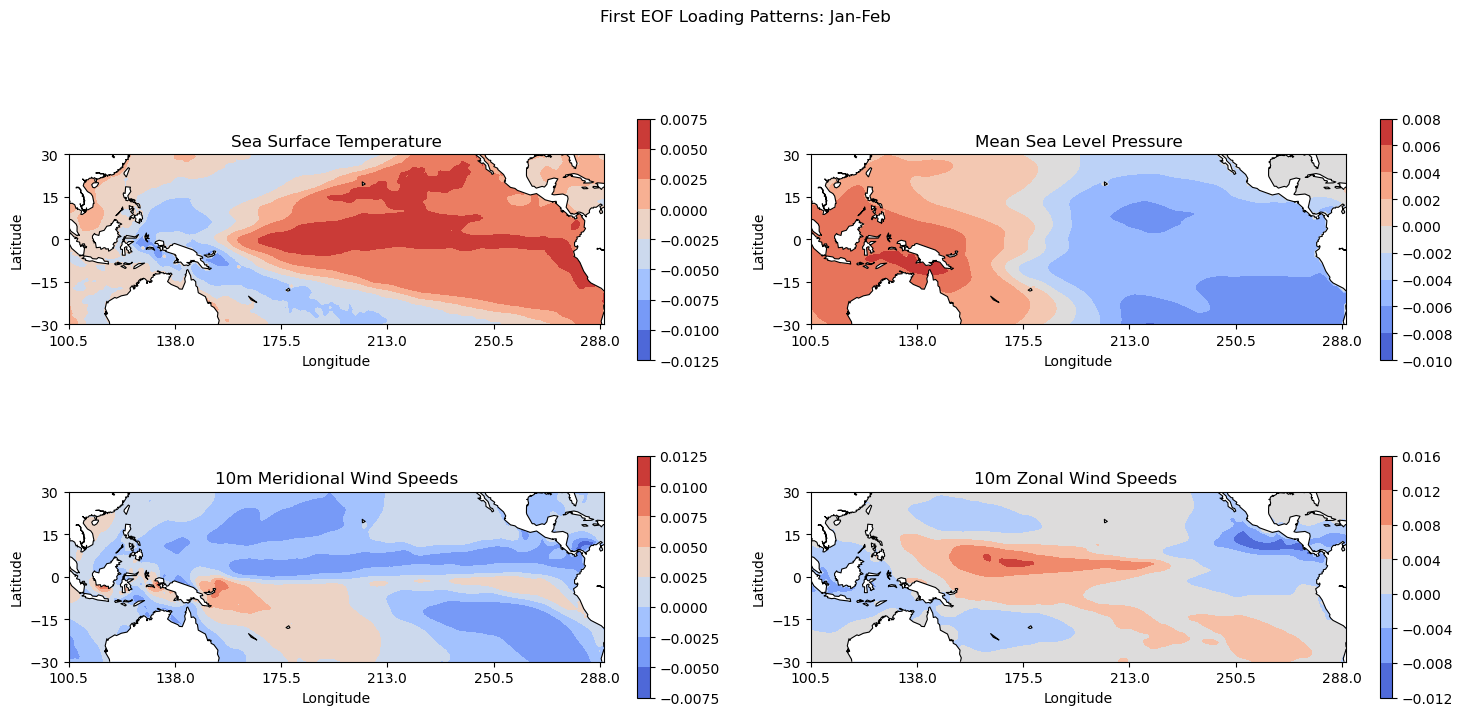

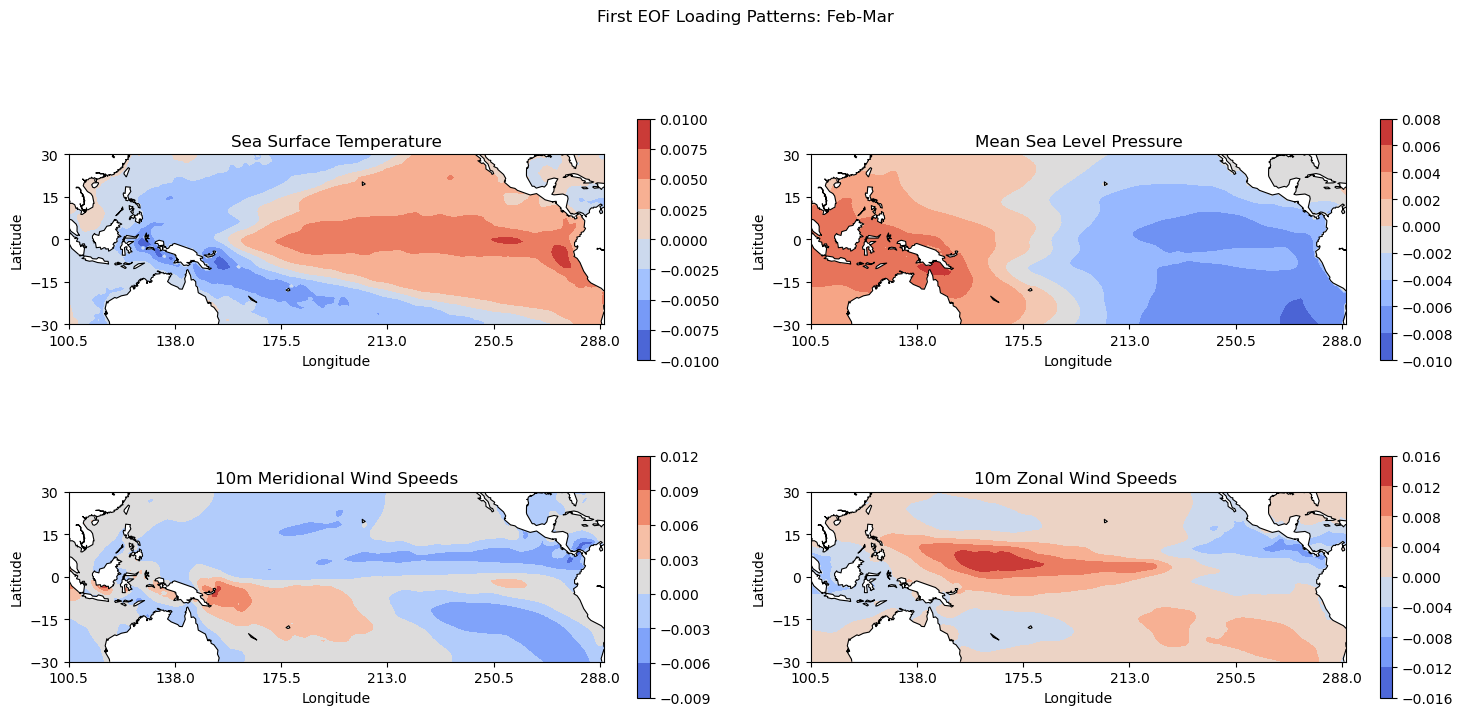

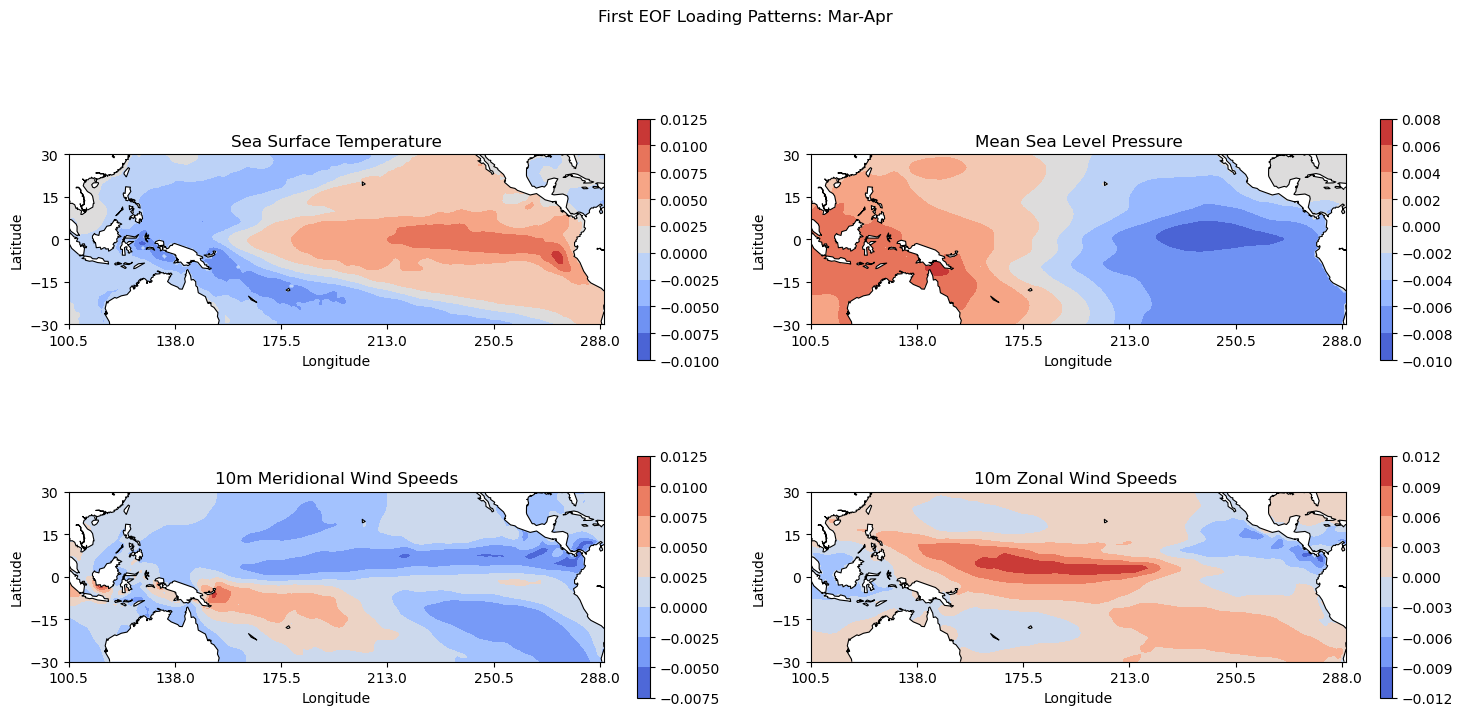

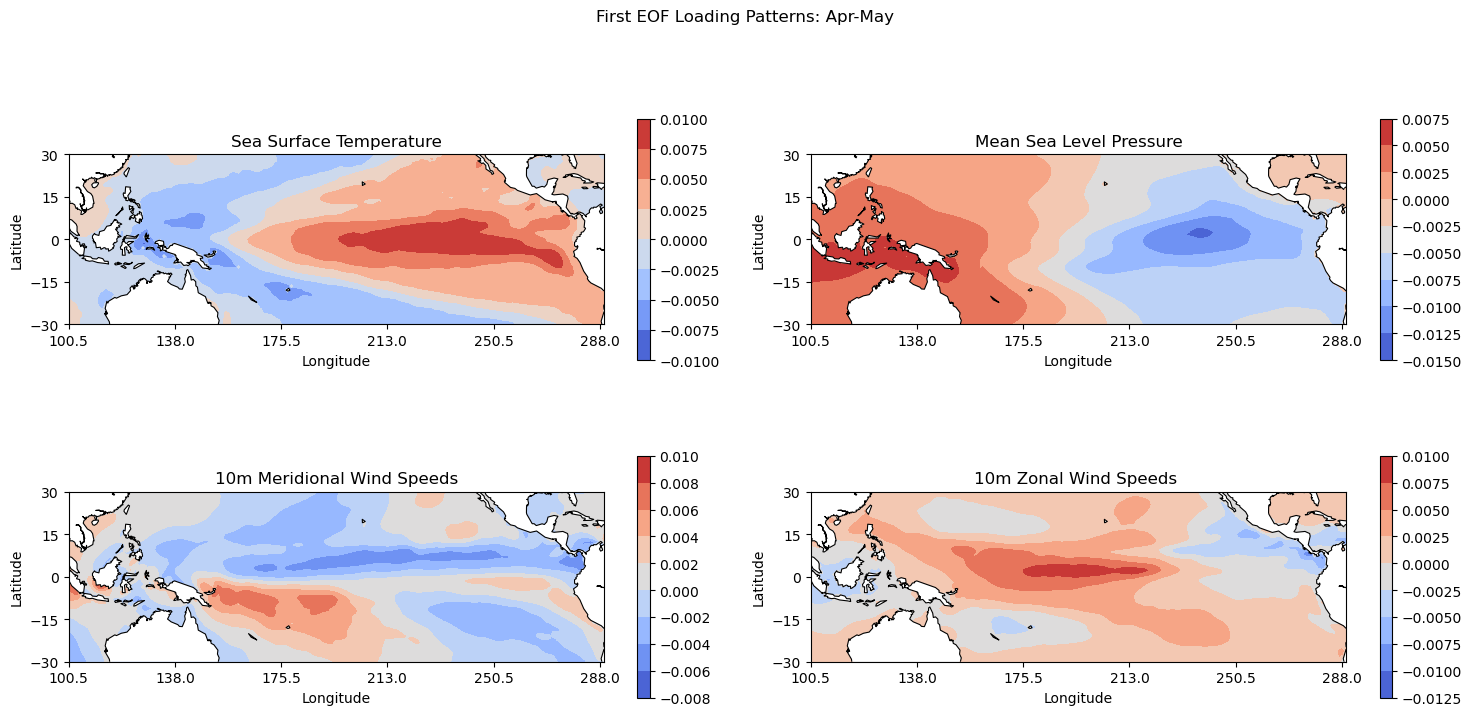

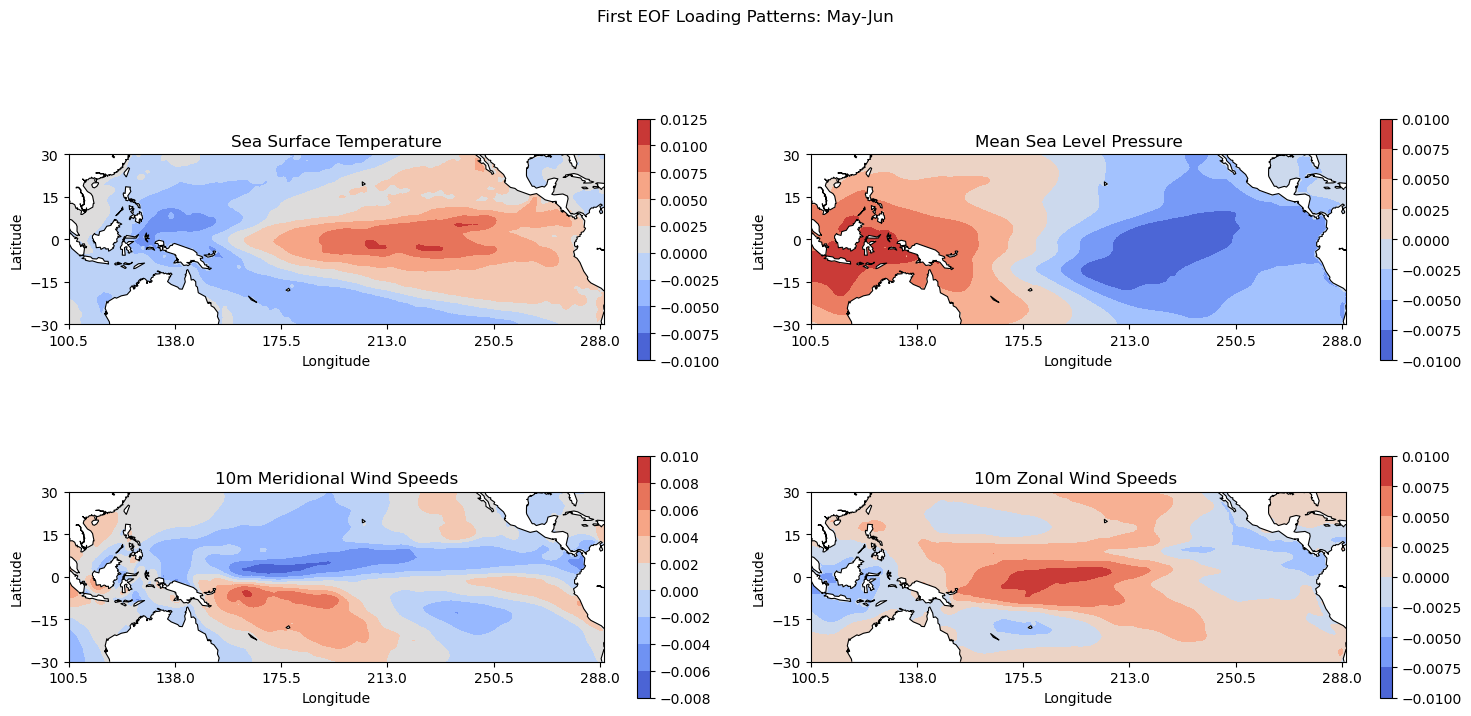

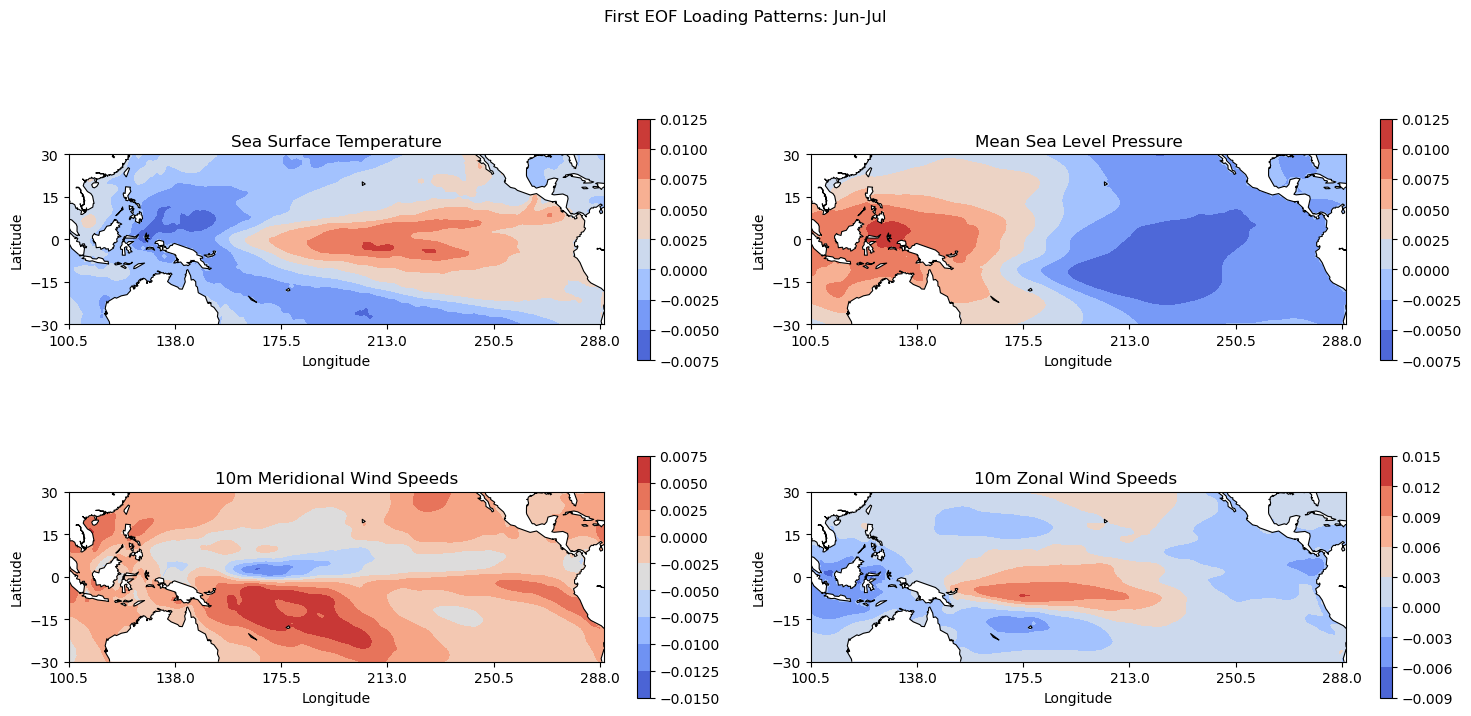

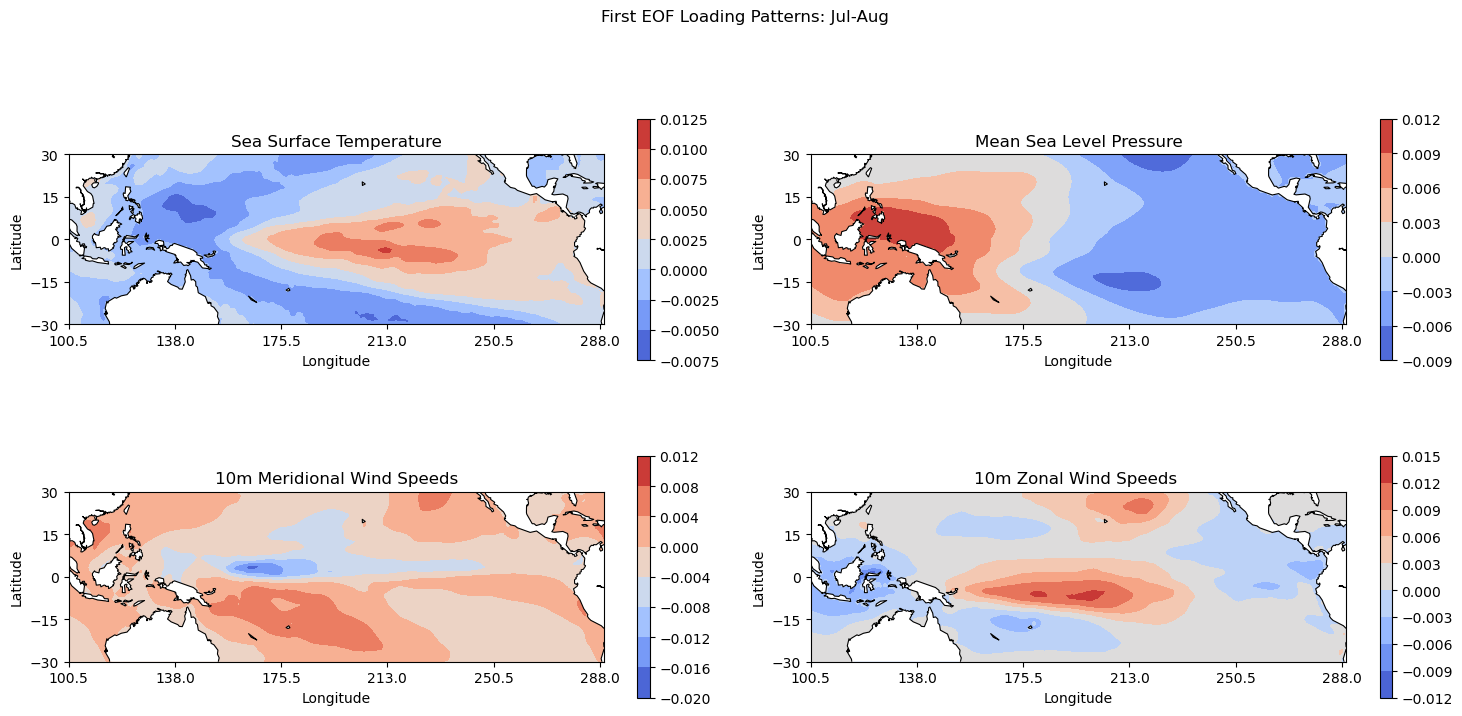

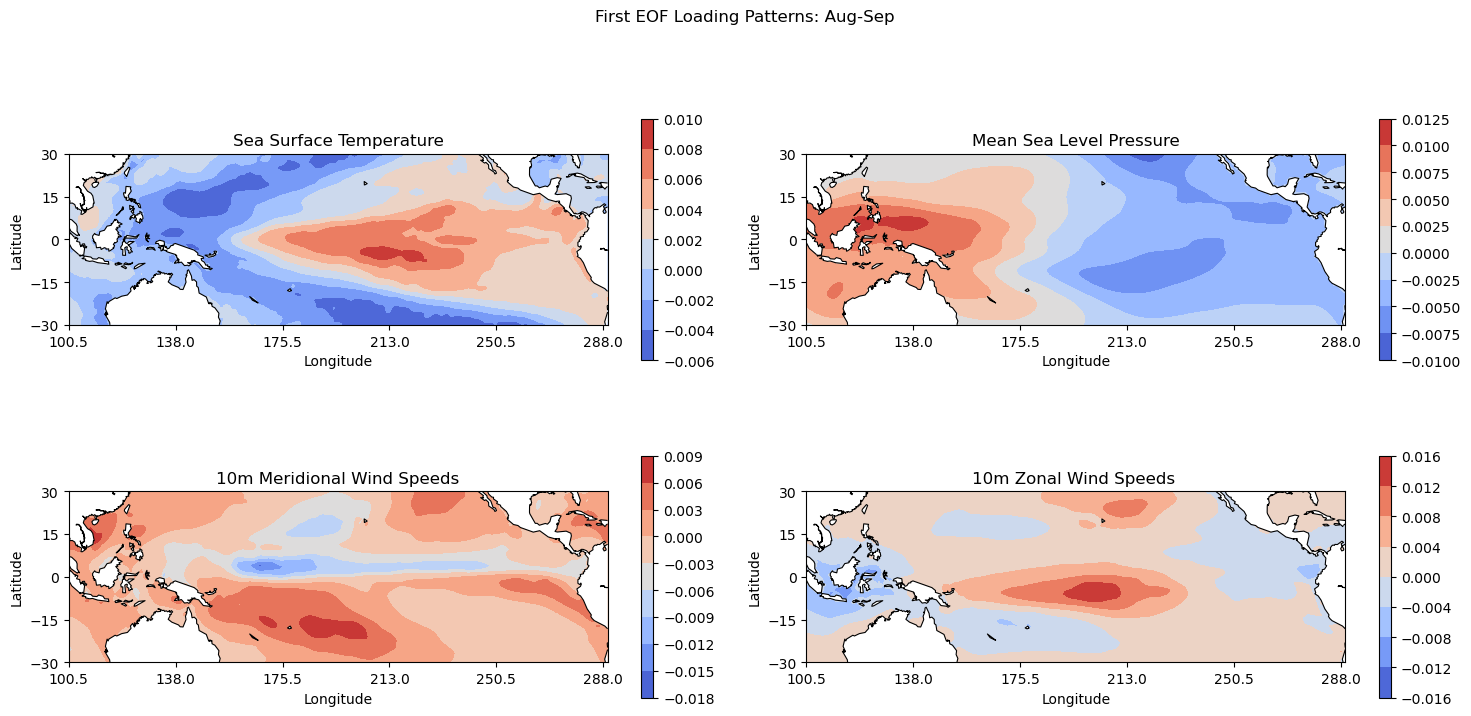

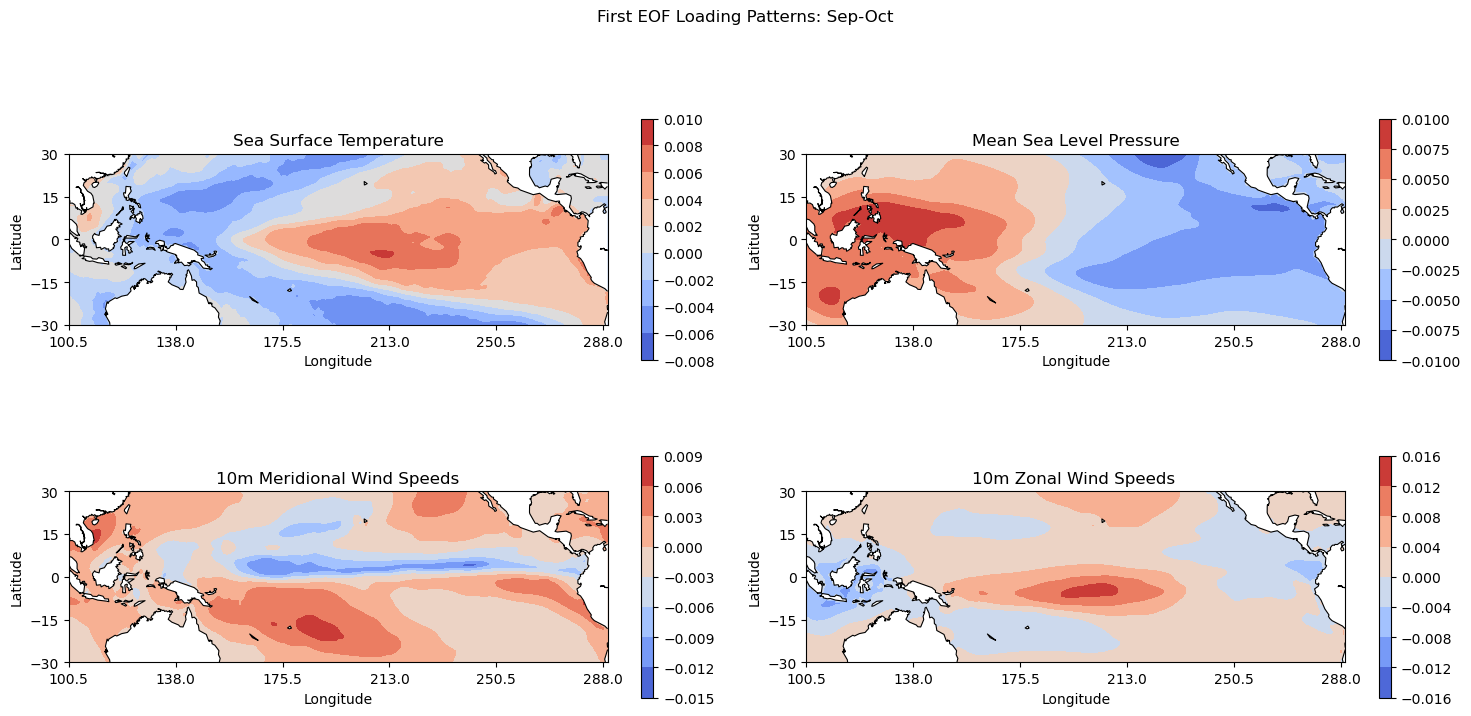

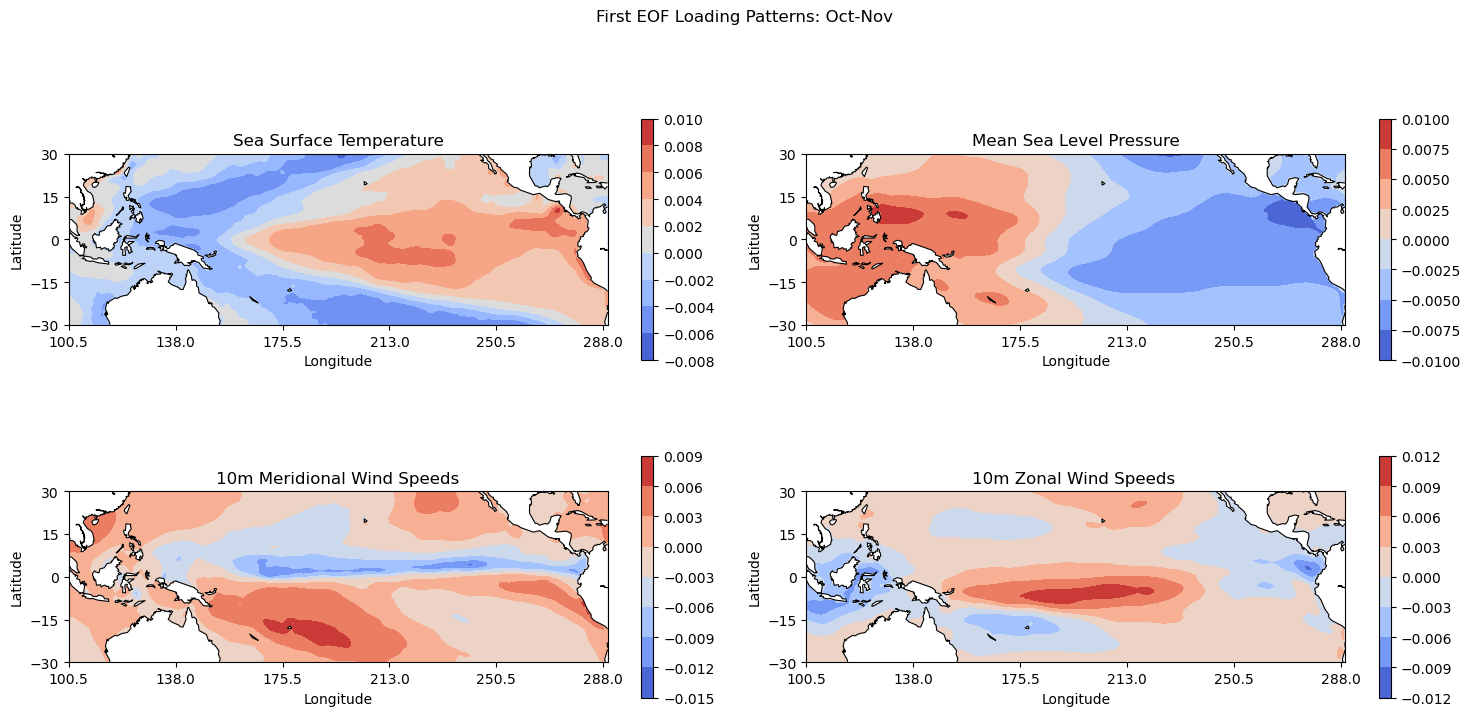

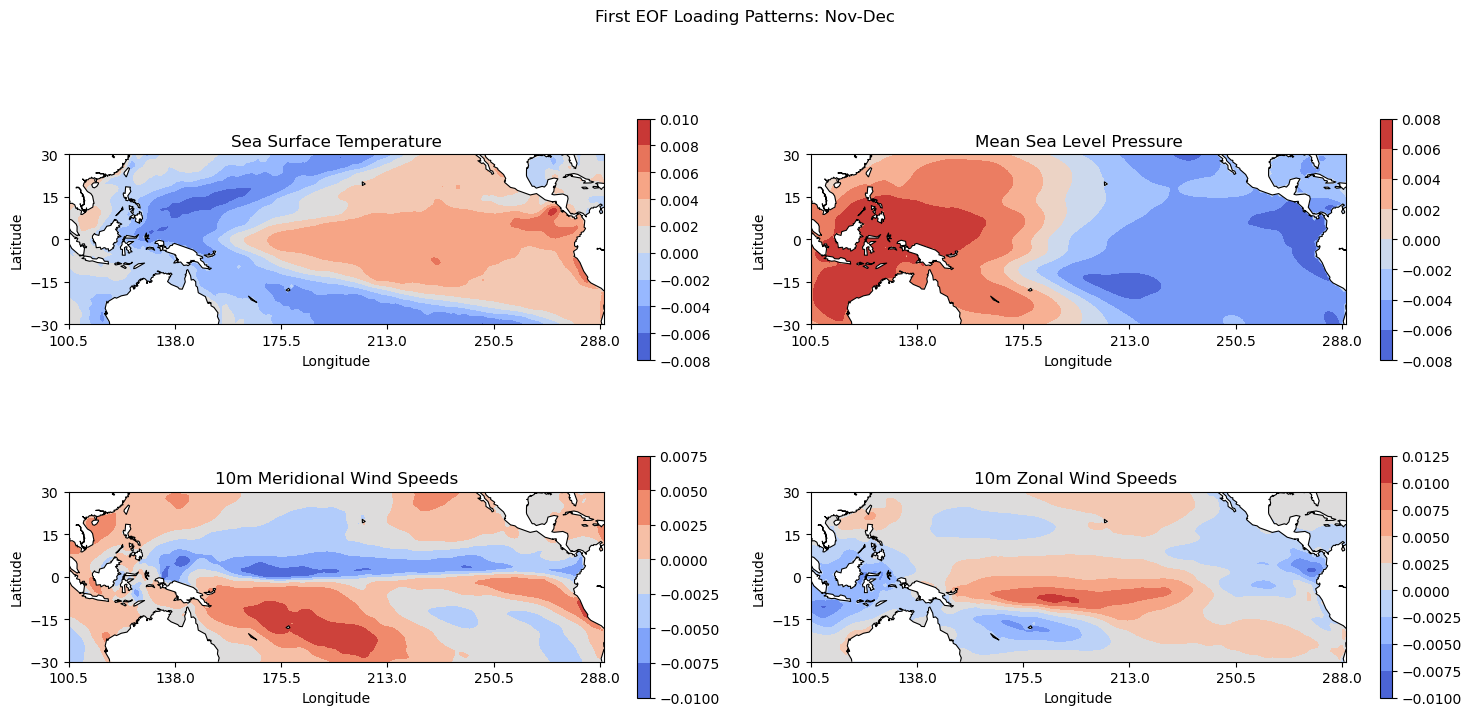

In [ ]:
# show loading pattern subplots -- figure out which ones need saving/separating
for i, eof in enumerate(eofs):
    plot_loadingPatterns(eof[0], bi_monthly_labels[i])

### NEXT TIME
- DISCUSS:
    - which plots are we using and how do we want them to look
        - i.e do we want subplots or not, which months, etc
    - do we need to flip any colours back around - note why we can do this and discuss in report ?
    - any other cosmetic changes

- ASK SEBASTIAN:
    - in getEof, is replacing the NaNs with 0s the correct thing to do?
    - is the scale ok (100x too small??)
    - how many plots/figures we can use in the report
    - is ensuring consistent sign convention ok